# Load Library

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np

from pylops.basicoperators import *
from pylops.optimization.sparsity import fista
from pylops.utils.metrics import snr
from pylops.basicoperators import FirstDerivative, Diagonal
from pylops.signalprocessing import FFT2D

from landmc.preprocessing import mask, mask_cut, subsample, fk_transform, fk_filter_design,plot_reconstruction_2d_real
from landmc.nmoinv import NMO
from landmc.slopes import multicomponent_slopes_inverse
from landmc.MCReconstruction import MCdata

import matplotlib.pyplot as plt
import cupy as cp
cp_asarray = cp.asarray
cp_asnumpy = cp.asnumpy

apply_nmo = True

# Parameter list

In [2]:
# Parameter for slope estimation inversion
slope_reg = 100 = 1e1# regularization factor for smoothing
niter_slopeest = 200 # number of iterations of lsqr
dict_slope_opt = dict(iter_lim=niter_slopeest) if not USE_CUPY else dict(niter=niter_slopeest) #solver parameter

# Interpolation parameter
USE_CUPY = True #to use GPU for running
eps_slopes = 1e1 # regularization factor for slope consistency term in inversion
eps_fk = 1e-3 # regularization factor for sparsity term
niter_fista = 100 # number of iterations of fista

#Plotting Params
clip_v = 5e-3
clip_fk = 0.1
fk_uplim = 100
slope_scale = 1e-5
save_fig_folder = "../figures/"
save_fig_folder = "/home/khatamm/Thesis Material/"
def plotting_style():
    """Plotting syle

    Define plotting style for the entire project

    """
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.style.use('default')

    plt.rc('text', usetex=True)
    plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('font', serif='Arial')  # fontsize of the figure title
plotting_style()

## Load data

In [3]:
file = np.load("../data/Synthetic Data_preprocessed.npz")
data = file['rec1'][:,::2] #subsample data in time 
d1_full = file['d1'].T[:,::2]

#Geometry
x = file['x']
t = file['t'][::2]  
dt = (t[1]-t[0])
dx = x[1]-x[0]

#Fourier Transform parameter
nfft_t, nfft_x = 2**12, 2**12

nx = data.shape[0]
nt = data.shape[1]

D, f, ks, Fop = fk_transform(data, nfft_x, nfft_t, dx, dt)

#Disp kwargs
show_seis_kwargs = dict(aspect='auto',cmap='seismic',vmin=-clip_v,vmax=clip_v,extent=(x[0]/1000, x[-1]/1000, t[-1], t[10]))
show_fk_kwargs = dict(cmap='gist_ncar_r',aspect='auto', 
                      extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]),vmin=0,vmax=clip_fk)

## Decimating Data

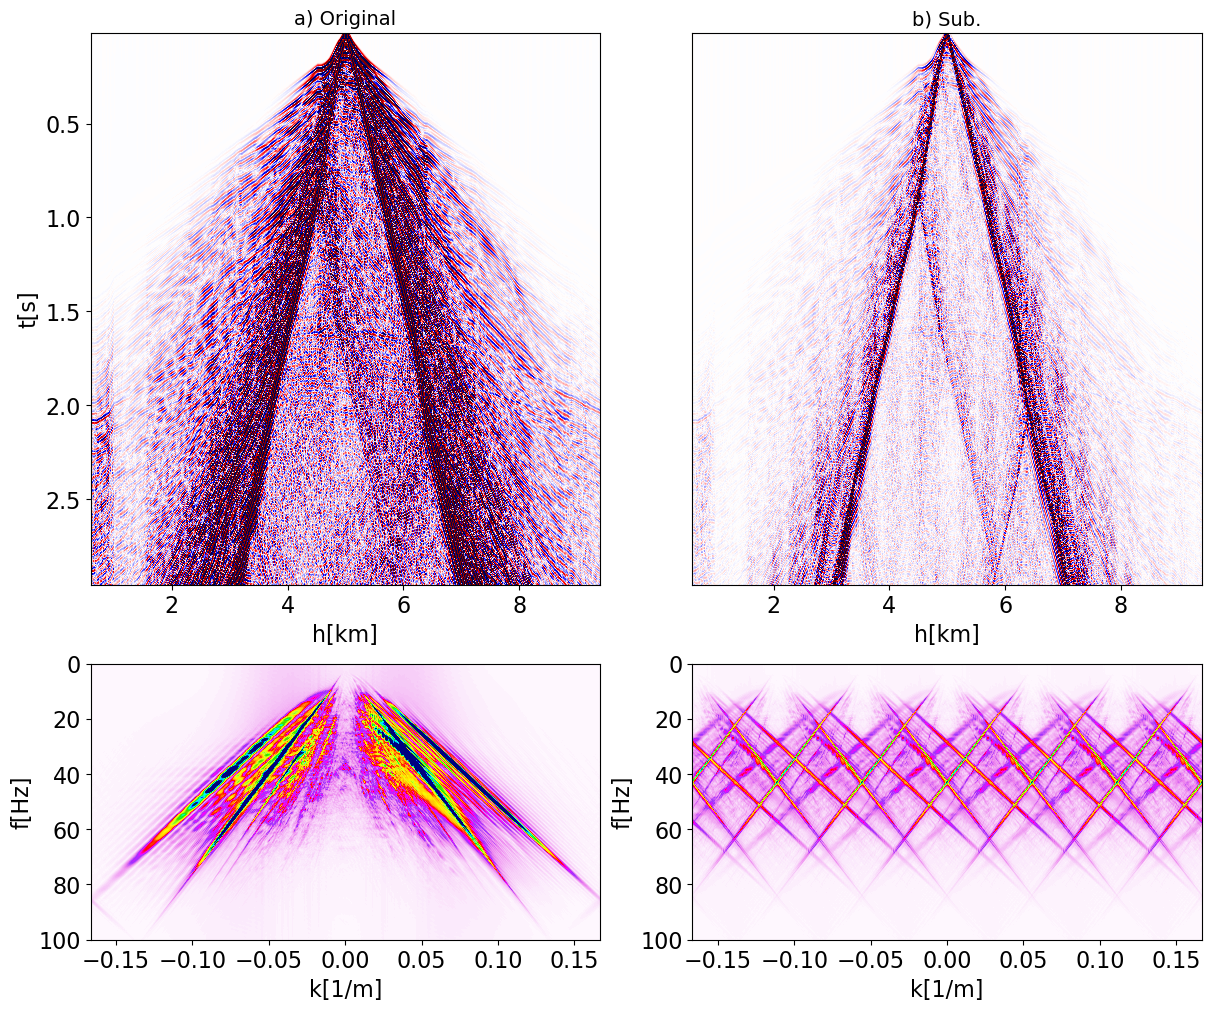

In [7]:
nsub = 6

#Subsample Data
data_obs, data_mask, Rop = subsample(data,nsub=nsub)
data_mask = data_mask.data

#Subsample Derivative
d1,d1_mask,_ = subsample(d1_full,nsub=nsub)

# Create Derivative operator in FK domain
ks_d1 = np.fft.fftfreq(nfft_x, dx)
coeff1 = 1j * 2 * np.pi * ks_d1
coeff1 = np.repeat(coeff1[:, np.newaxis], nfft_t//2+1, axis=1).ravel()
D1op = Diagonal(coeff1)

D_sub, f, ks,_ = fk_transform(data_mask, nfft_x, nfft_t, dx, dt)
D1_sub, _, _,_ = fk_transform(d1_mask, nfft_x, nfft_t, dx, dt)

sc1 = np.max(np.abs(data_obs)) / np.max(np.abs(d1))

fig = plt.figure(constrained_layout=True, figsize=(12, 10))
axs = []
gs = fig.add_gridspec(3, 2)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))

axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))

axs[0].imshow(data.T, **show_seis_kwargs)
axs[0].set_title('a) Original', fontsize=14)
axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')

axs[1].imshow(data_mask.T, **show_seis_kwargs)
axs[1].set_title('b) Sub.', fontsize=14)
axs[1].axis('tight')
axs[1].set_xlabel('h[km]')
axs[1].set_yticks([], [])

axs[2].imshow(np.fft.fftshift(np.abs(D).T, axes=1), **show_fk_kwargs)
axs[2].set_xlim(-(1/(2*dx)),(1/(2*dx)));
# axs[2].set_xlim(-0.08,0.08);
axs[2].set_ylim(fk_uplim, 0)
axs[2].set_ylabel('f[Hz]')
axs[2].set_xlabel('k[1/m]')

axs[3].imshow(np.fft.fftshift(np.abs(D_sub).T, axes=1), **show_fk_kwargs)
axs[3].set_xlim(-(1/(2*dx)),(1/(2*dx)));
axs[3].set_ylim(fk_uplim, 0)
axs[3].set_ylabel('f[Hz]')
axs[3].set_xlabel('k[1/m]')

plt.show()

## Set up FK Mask

In [23]:
# F-K masking
vel = 450. # velocity
fmax = 100 # maximum frequency
critical = 1.00 # scaling to be applied to the f=k*v line used to create the mask
koffset = 0.001 # shift to be applied to the f=k*v line used to create the mask

mask_fk = fk_filter_design(f, ks, vel, fmax, critical=critical, koffset=koffset)
Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex)

/tmp/ipykernel_248436/429261162.py:8: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Mf = Diagonal(mask_fk.astype(np.complex).T.ravel(), dtype=np.complex)


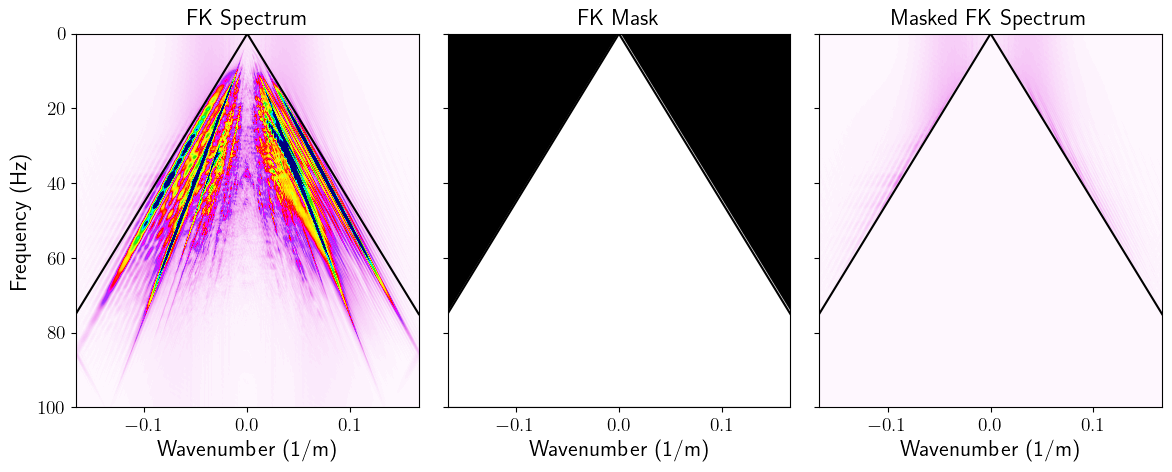

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 5))
axs[0].imshow(np.fft.fftshift(np.abs(D).T, axes=1), **show_fk_kwargs)

axs[0].plot(f/vel, f,'k'), axs[0].plot(-f/vel, f,'k')
axs[0].set_xlim(-1/(2*dx), 1/(2*dx))
axs[0].set_xlabel('Wavenumber (1/m)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title('FK Spectrum')

axs[1].imshow(np.fft.fftshift(mask_fk, axes=1), cmap='gray',aspect='auto',
              extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[nfft_t//2-1], f[0]))

axs[1].plot(f/vel, f,'k'), axs[1].plot(-f/vel, f,'k')
axs[1].set_xlim(-1/(2*dx), 1/(2*dx))
axs[1].set_xlabel('Wavenumber (1/m)')
axs[1].set_title('FK Mask')

axs[2].imshow(np.fft.fftshift((1-mask_fk)*np.abs(D).T, axes=1), **show_fk_kwargs)

axs[2].plot(f/vel, f,'k'), axs[2].plot(-f/vel, f,'k')
axs[2].set_xlim(-1/(2*dx), 1/(2*dx))
axs[2].set_ylim(fk_uplim, 0)
axs[2].set_xlabel('Wavenumber (1/m)')
axs[2].set_title('Masked FK Spectrum')
plt.tight_layout()

## Set up T-X Mask

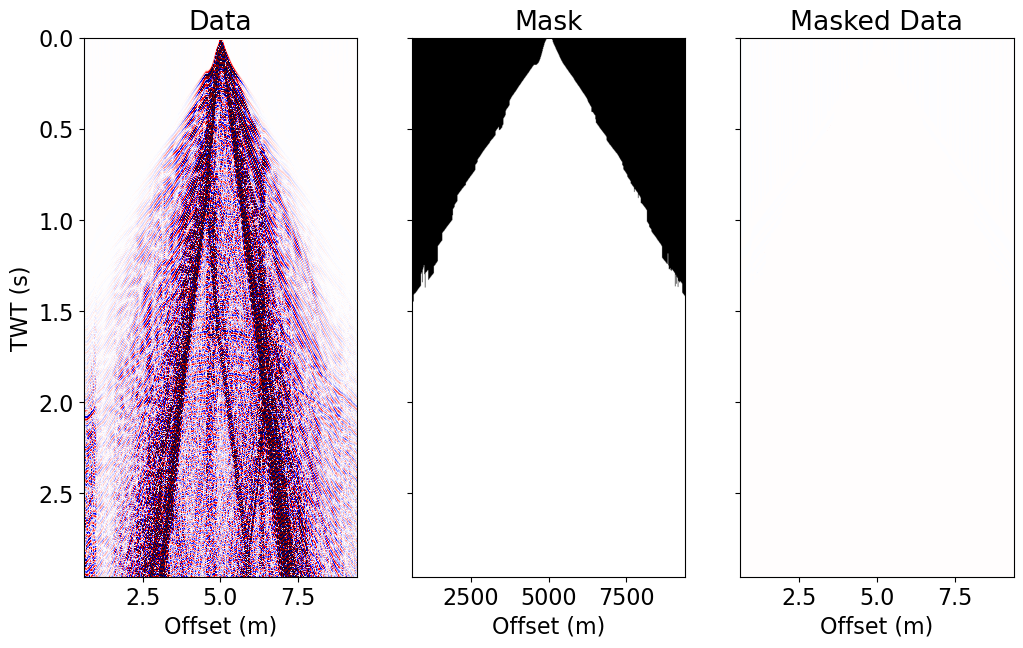

In [10]:
# Calculate time-space mask
# mask_thresh = 0.000001
mask_thresh = 0.00005
maskt = mask(Rop.H @ data_obs, mask_thresh,itoff=10)
# data_obs = Rop*(maskt*data_mask)
# d1 = Rop*(maskt*d1_mask)
 
fig, axs = plt.subplots(1, 3, figsize=(12, 7), sharey=True)
axs[0].imshow(data_obs.T, **show_seis_kwargs)
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].axis('tight')

axs[1].imshow(maskt.T, cmap='gray', vmin=0, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('Mask')
axs[1].axis('tight')

axs[2].imshow((1-(Rop * maskt).T)*data_obs.T, **show_seis_kwargs)
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('Masked Data')
axs[2].axis('tight');

## Reconstruction

In [11]:
sc1 = np.max(np.abs(data_obs)) / np.max(np.abs(d1))
Data = MCdata(data_obs,d1,x,t,sc1,Rop,D1op,Fop,Mf,nsub,fulldata_grid=data)
Data.estimate_slope(reg=slope_reg,use_weighted=True)

In [12]:
#Soft Constraint using FISTA
xinv2 = Data.MC_inversion_FISTA(niter_fista,9e-4,firstgrad=True,slope=True)

/home/khatamm/anaconda3/envs/landmc/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 7229590 rows and 8392704 cols
eps = 9.000000e-04	tol = 1.000000e-10	niter = 100
alpha = 5.501571e-01	thresh = 2.475707e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    1.622e+02   1.670e+02   8.466e+00
     2   -0.00e+00+0.00e+00j    1.105e+02   1.181e+02   5.662e+00
     3   -0.00e+00+0.00e+00j    7.433e+01   8.430e+01   5.372e+00
     4   -0.00e+00+0.00e+00j    5.069e+01   6.258e+01   4.852e+00
     5   -0.00e+00+0.00e+00j    3.579e+01   4.917e+01   4.262e+00
     6   -0.00e+00+0.00e+00j    2.648e+01   4.096e+01   3.693e+00
     7   -0.00e+00+0.00e+00j    2.044e+01   3.573e+01   3.206e+00
     8   -0.00e+00+0.00e+00j    1.621e+01   3.205e+01   2.839e+00
     9   -0.00e+00+0.00e+00j    1.300e+01   2.920e+01   2.587e+00
    10   -

In [13]:
#Hard Constraint using Primal-Dual
L = 10 # np.real((Dop.H*Dop).eigs(neigs=1, which='LM')[0])
tau = 0.99
mu = 0.99 /(tau*L)
print(mu*tau*(L))
print(tau)
print(mu)
niterPD = 100
xinvPD = Data.MC_inversion_PD(niterPD,tau,mu)

0.9899999999999999
0.99
0.09999999999999999
Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.AffineSet.AffineSet'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.vstack.VStack'>
Additional vector (z): None
tau = 0.99		mu = 0.09999999999999999
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1  -2.71314e-07   0.000e+00   1.079e+02   0.000e+00       1.079e+02
     2  -2.71314e-07   0.000e+00   9.949e+01   0.000e+00       9.949e+01
     3  -2.71314e-07   0.000e+00   8.918e+01   0.000e+00       8.918e+01
     4  -2.71314e-07   0.000e+00   7.841e+01   0.000e+00       7.841e+01
     5  -2.71314e-07   0.000e+00   6.825e+01   0.000e+00       6.825e+01
     6  -2.71314e-07   0.000e+00   5.934e+01   0.000e+00       5.934e+01
     7  -2.71314e-07   0.000e+00   5.191e+01 

In [14]:
#Regular survey comparison
nsub = 3

#Subsample Data
data_obs3, data_mask3, Rop3 = subsample(data,nsub=nsub)
data_mask3 = data_mask3.data

#Subsample Derivative
d13,d1_mask3,_ = subsample(d1_full,nsub=nsub)

In [42]:
slope_reg = 100
sc1 = np.max(np.abs(data_obs)) / np.max(np.abs(d13))
Data = MCdata(data_obs3,d13,x,t,sc1,Rop3,D1op,Fop,Mf,nsub,fulldata_grid=data)
Data.estimate_slope(reg=slope_reg,use_weighted=True)
xinv3 = Data.MC_inversion_FISTA(niter_fista,1e-3,firstgrad=False,slope=False)

/home/khatamm/anaconda3/envs/landmc/lib/python3.10/site-packages/pylops/basicoperators/restriction.py:147: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iavamask] = x.ravel()


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 1808322 rows and 8392704 cols
eps = 1.000000e-03	tol = 1.000000e-10	niter = 100
alpha = 1.090652e+00	thresh = 5.453262e-04
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    6.013e+01   7.230e+01   2.250e+01
     2   -0.00e+00+0.00e+00j    1.854e+01   3.403e+01   7.744e+00
     3   -0.00e+00+0.00e+00j    5.330e+00   2.269e+01   4.845e+00
     4   -0.00e+00+0.00e+00j    1.219e+00   1.944e+01   3.105e+00
     5   -0.00e+00+0.00e+00j    3.120e-01   1.890e+01   1.801e+00
     6   -0.00e+00+0.00e+00j    2.455e-01   1.893e+01   8.416e-01
     7   -0.00e+00+0.00e+00j    2.484e-01   1.888e+01   3.738e-01
     8   -0.00e+00+0.00e+00j    2.321e-01   1.876e+01   3.925e-01
     9   -0.00e+00+0.00e+00j    2.313e-01   1.863e+01   4.301e-01
    10   -

# Plotting

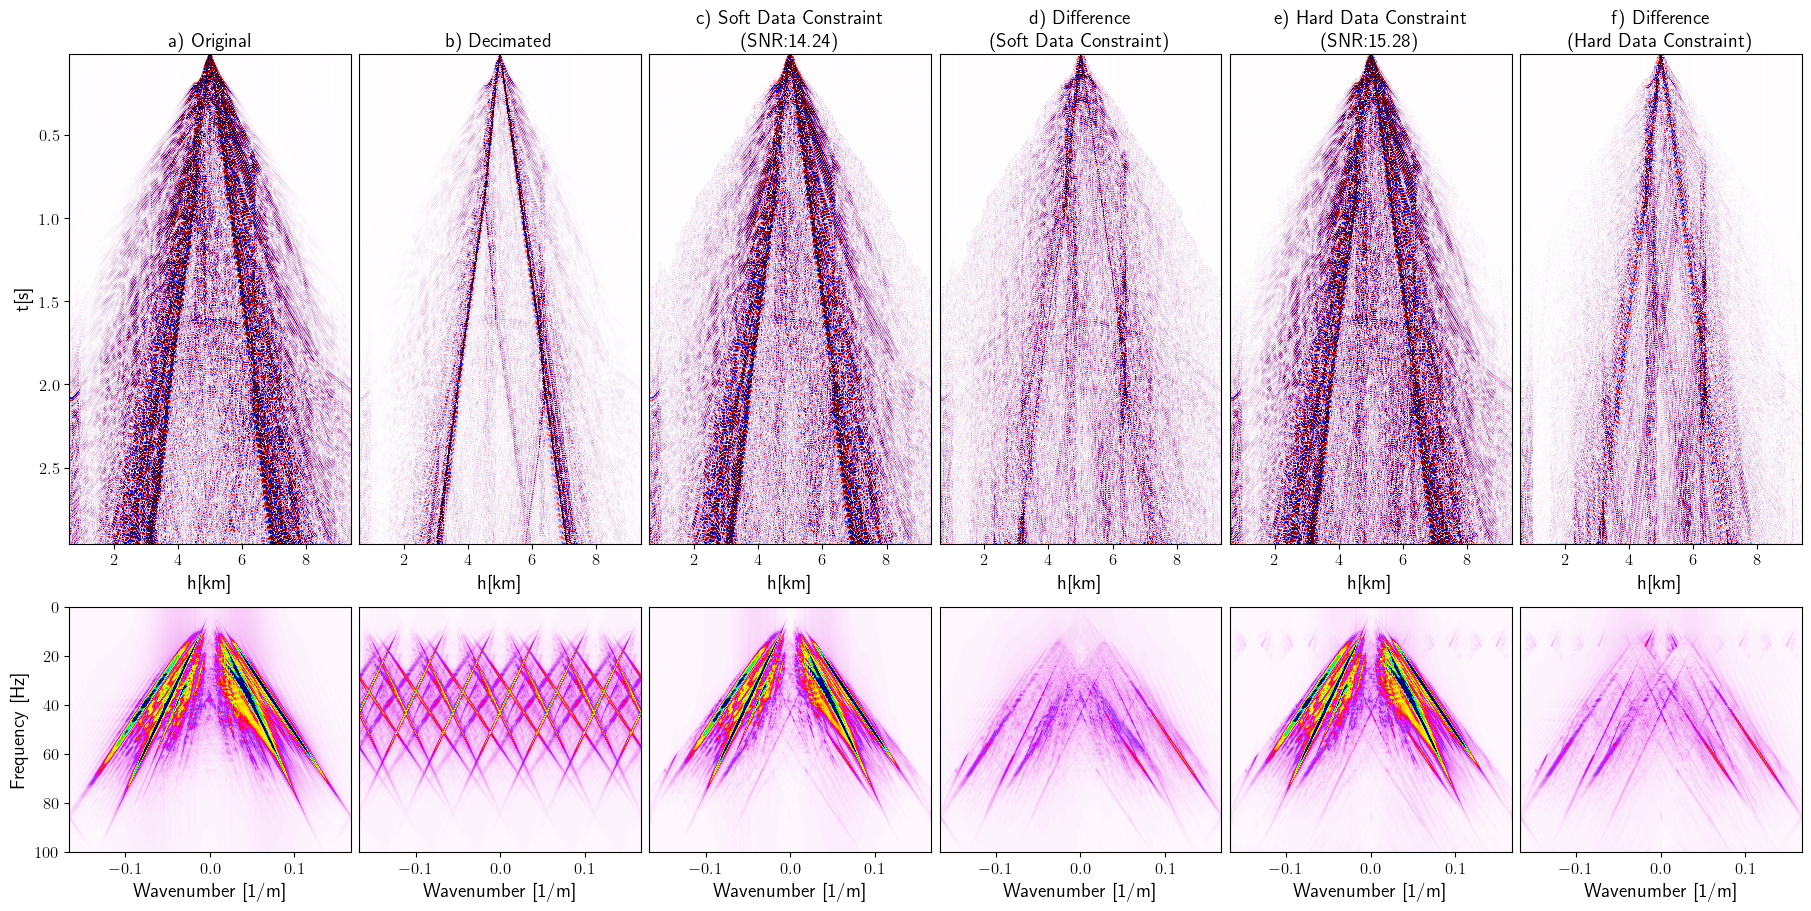

In [14]:
#Soft and Hard data constraint comparison
from pylops.utils.metrics import snr
show_seis_kwargs = dict(aspect='auto',cmap='seismic',vmin=-clip_v,vmax=clip_v,extent=(x[0]/1000, x[-1]/1000, t[-1], t[10]))
show_fk_kwargs = dict(cmap='gist_ncar_r',aspect='auto', 
                      extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]),vmin=0,vmax=clip_fk)

fig = plt.figure(constrained_layout=True, figsize=(18, 9))
axs = []
gs = fig.add_gridspec(3, 6)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[:2, 2]))
axs.append(fig.add_subplot(gs[:2, 3]))
axs.append(fig.add_subplot(gs[:2, 4]))
axs.append(fig.add_subplot(gs[:2, 5]))
axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))
axs.append(fig.add_subplot(gs[2:, 2]))
axs.append(fig.add_subplot(gs[2:, 3]))
axs.append(fig.add_subplot(gs[2:, 4]))
axs.append(fig.add_subplot(gs[2:, 5]))

axs[0].imshow((data).T, **show_seis_kwargs)
axs[0].set_title('a) Original ', fontsize=14)
axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')

axs[1].imshow((data_mask).T, **show_seis_kwargs)
axs[1].set_title('b) Decimated ', fontsize=14)
axs[1].axis('tight')
axs[1].set_xlabel('h[km]')
# axs[0,1].set_yticks([], [])

axs[2].imshow((maskt*xinv2).T, **show_seis_kwargs)
axs[2].set_title('c) Soft Data Constraint \n (SNR:%.2f)'%(snr(maskt*xinv2,data)), fontsize=14)
axs[2].axis('tight')
axs[2].set_xlabel('h[km]')
# axs[0,2].set_yticks([], [])

axs[3].imshow((maskt*xinv2-data).T, **show_seis_kwargs)
axs[3].set_title('d) Difference \n (Soft Data Constraint)', fontsize=14)
axs[3].axis('tight')
axs[3].set_xlabel('h[km]')

axs[4].imshow((maskt*xinvPD).T, **show_seis_kwargs)
axs[4].set_title('e) Hard Data Constraint \n (SNR:%.2f)'%(snr(maskt*xinvPD,data)), fontsize=14)
axs[4].axis('tight')
axs[4].set_xlabel('h[km]')
# axs[0,3].set_yticks([], [])

axs[5].imshow((maskt*xinvPD-data).T, **show_seis_kwargs)
axs[5].set_title('f) Difference \n (Hard Data Constraint)' , fontsize=14)
axs[5].axis('tight')
axs[5].set_xlabel('h[km]')

axs[6].imshow(np.fft.fftshift(np.abs((D).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs )
axs[6].set_xlim(-1/(2*dx), 1/(2*dx))
axs[6].set_ylim(fk_uplim, f[0])
axs[6].set_xlabel('Wavenumber [1/m]')
axs[6].set_ylabel('Frequency [Hz]')

axs[7].imshow(np.fft.fftshift(np.abs((Fop*data_mask.ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[7].set_xlim(-1/(2*dx), 1/(2*dx))
axs[7].set_ylim(fk_uplim, f[0])
axs[7].set_xlabel('Wavenumber [1/m]')

axs[8].imshow(np.fft.fftshift(np.abs((Fop*(maskt*xinv2).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[8].set_xlim(-1/(2*dx), 1/(2*dx))
axs[8].set_ylim(fk_uplim, f[0])
axs[8].set_xlabel('Wavenumber [1/m]')

axs[9].imshow(np.fft.fftshift(np.abs((Fop*(maskt*xinv2-data).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[9].set_xlim(-1/(2*dx), 1/(2*dx))
axs[9].set_ylim(fk_uplim, f[0])
axs[9].set_xlabel('Wavenumber [1/m]')

axs[10].imshow(np.fft.fftshift(np.abs((Fop*(maskt*xinvPD).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[10].set_xlim(-1/(2*dx), 1/(2*dx))
axs[10].set_ylim(fk_uplim, f[0])
axs[10].set_xlabel('Wavenumber [1/m]')

axs[11].imshow(np.fft.fftshift(np.abs((Fop*(maskt*xinvPD-data).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[11].set_xlim(-1/(2*dx), 1/(2*dx))
axs[11].set_ylim(fk_uplim, f[0])
axs[11].set_xlabel('Wavenumber [1/m]')

for i in range(len(axs)):
    if i!=0 and i!=6:
        axs[i].set_yticks([], [])

plt.savefig(save_fig_folder+"Figure1_Synthetic Reconstruction", format='eps')

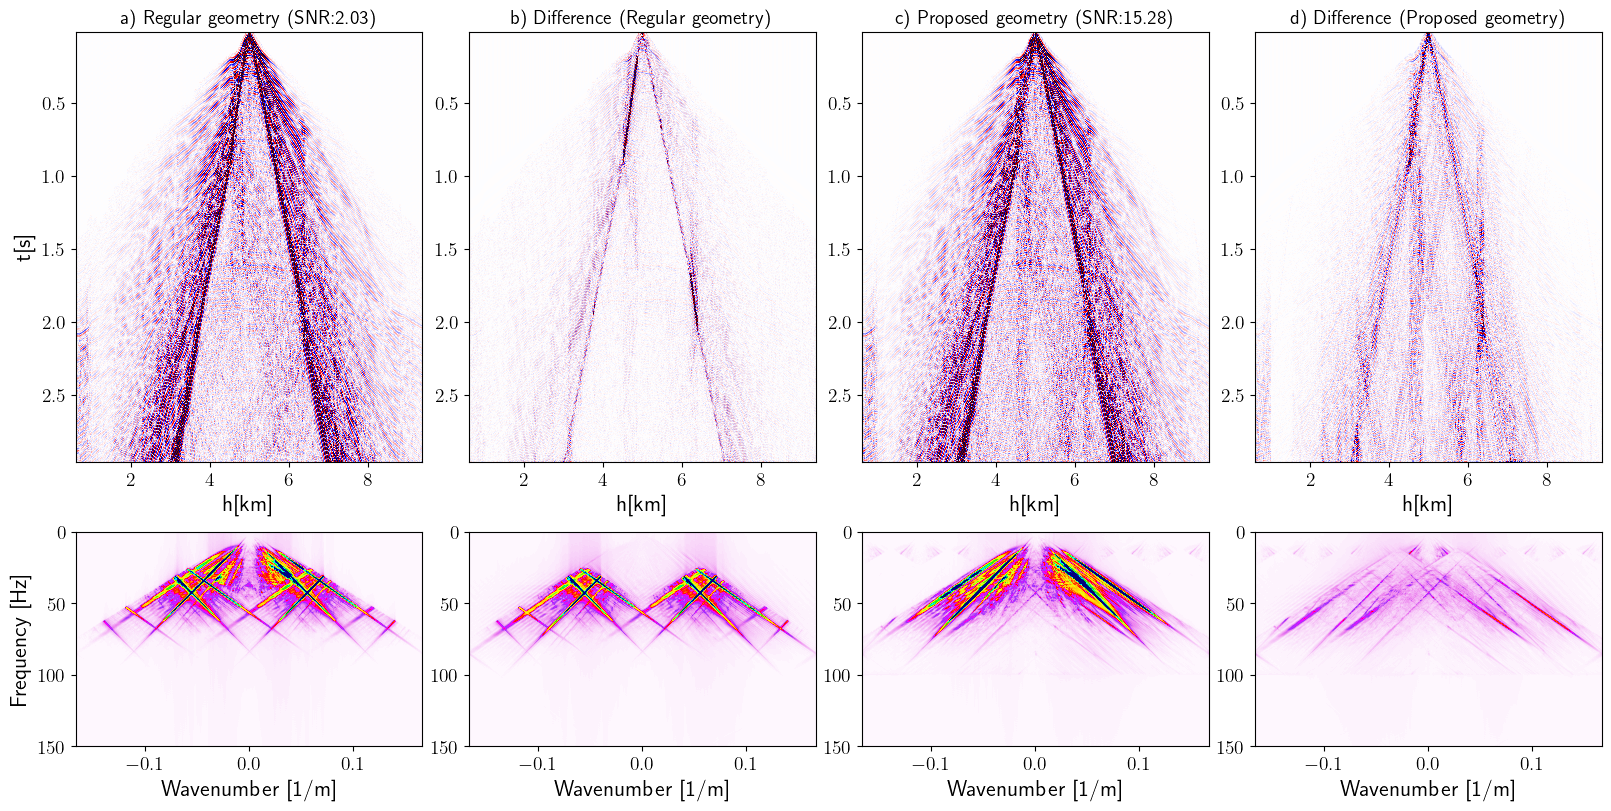

In [43]:
#Regular and proposed geometry comparison
from pylops.utils.metrics import snr
show_seis_kwargs = dict(aspect='auto',cmap='seismic',vmin=-clip_v,vmax=clip_v,extent=(x[0]/1000, x[-1]/1000, t[-1], t[10]))
show_fk_kwargs = dict(cmap='gist_ncar_r',aspect='auto', 
                      extent=(np.fft.fftshift(ks)[0], np.fft.fftshift(ks)[-1], f[-1], f[0]),vmin=0,vmax=clip_fk)

fig = plt.figure(figsize=(16, 8),constrained_layout=True)
axs = []
gs = fig.add_gridspec(3, 4)
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1]))
axs.append(fig.add_subplot(gs[:2, 2]))
axs.append(fig.add_subplot(gs[:2, 3]))
axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))
axs.append(fig.add_subplot(gs[2:, 2]))
axs.append(fig.add_subplot(gs[2:, 3]))

axs[0].imshow((maskt*xinv3).T, **show_seis_kwargs)
axs[0].set_title('a) Regular geometry (SNR:%.2f)'%(snr(maskt*xinv3,data)), fontsize=14)
axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')

axs[1].imshow((maskt*xinv3-data).T, **show_seis_kwargs)
axs[1].set_title('b) Difference (Regular geometry)', fontsize=14)
axs[1].axis('tight')
axs[1].set_xlabel('h[km]')
# axs[0,1].set_yticks([], [])

axs[2].imshow((maskt*xinvPD).T, **show_seis_kwargs)
axs[2].set_title('c) Proposed geometry (SNR:%.2f)'%(snr(maskt*xinvPD,data)), fontsize=14)
axs[2].axis('tight')
axs[2].set_xlabel('h[km]')
# axs[0,2].set_yticks([], [])

axs[3].imshow((maskt*xinvPD-data).T, **show_seis_kwargs)
axs[3].set_title('d) Difference (Proposed geometry)', fontsize=14)
axs[3].axis('tight')
axs[3].set_xlabel('h[km]')

axs[4].imshow(np.fft.fftshift(np.abs((Fop*xinv3.ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs )
axs[4].set_xlim(-1/(2*dx), 1/(2*dx))
axs[4].set_ylim(150, f[0])
axs[4].set_xlabel('Wavenumber [1/m]')
axs[4].set_ylabel('Frequency [Hz]')

axs[5].imshow(np.fft.fftshift(np.abs((Fop*(data-xinv3)).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[5].set_xlim(-1/(2*dx), 1/(2*dx))
axs[5].set_ylim(150, f[0])
axs[5].set_xlabel('Wavenumber [1/m]')

axs[6].imshow(np.fft.fftshift(np.abs((Fop*(maskt*xinvPD).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[6].set_xlim(-1/(2*dx), 1/(2*dx))
axs[6].set_ylim(150, f[0])
axs[6].set_xlabel('Wavenumber [1/m]')

axs[7].imshow(np.fft.fftshift(np.abs((Fop*(maskt*xinvPD-data).ravel()).reshape(nfft_x,nfft_t//2+1)), axes=0).T, **show_fk_kwargs)
axs[7].set_xlim(-1/(2*dx), 1/(2*dx))
axs[7].set_ylim(150, f[0])
axs[7].set_xlabel('Wavenumber [1/m]')
save_fig_folder = "/home/khatamm/Thesis Material/"
plt.savefig(save_fig_folder+'Regular comparison-syn.eps',format='eps')

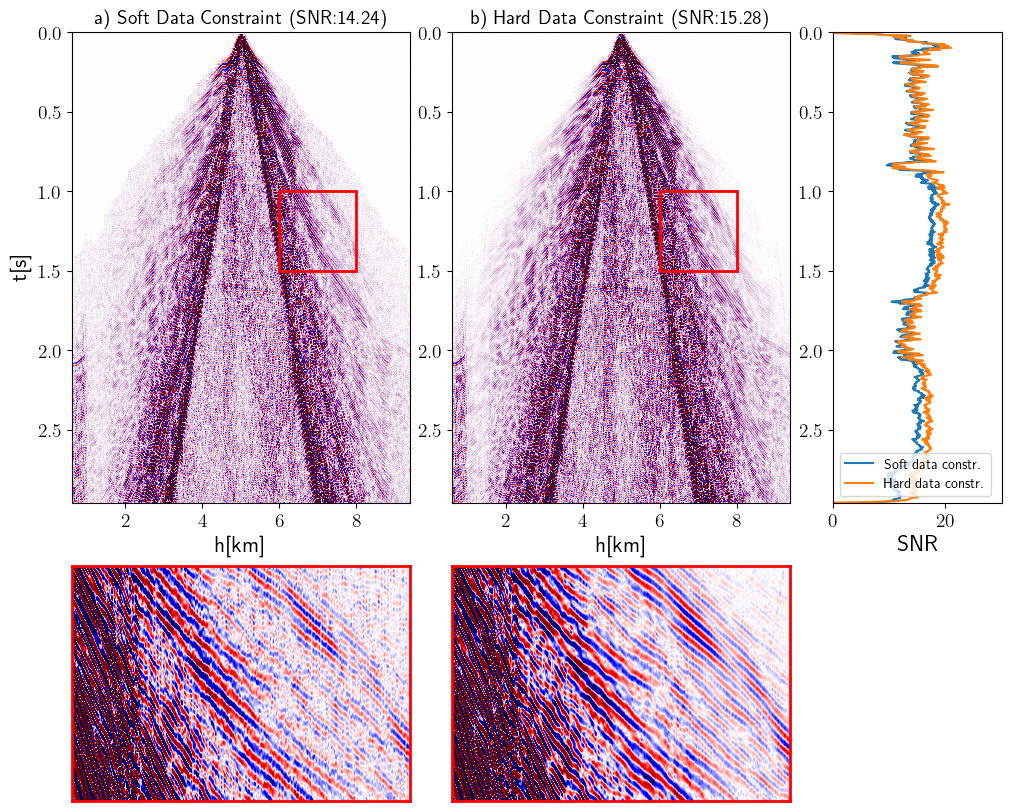

In [29]:
#Zoom in comparison
import matplotlib.patches as patches
data_recover = maskt*xinv2
data_recover_PD = maskt*xinvPD_mask

snr_space = np.zeros(data_recover.shape[0])
snr_time = np.zeros(data_recover.shape[1])

snr_space_PD = snr_space.copy()
snr_time_PD = snr_time.copy()

for i in range(len(snr_space)):
    snr_space[i] = snr(data_recover[i,:],data[i,:])
    snr_space_PD[i] = snr(data_recover_PD[i,:],data[i,:])
for i in range(len(snr_time)):
    snr_time[i] = snr(data_recover[:,i],data[:,i])
    snr_time_PD[i] = snr(data_recover_PD[:,i],data[:,i])

x_start = len(x[x<6000])
x_finish = len(x[x<8000])
t_start = len(t[t<1])
t_finish = len(t[t<1.5])

rect1 = patches.Rectangle(
    (6, 1),          # lower-left corner (x=5, y=1)
    8 - 6,           # width=2
    1.5 - 1,         # height=0.5
    fill=False, 
    edgecolor="red", 
    linewidth=2
)
rect2 = patches.Rectangle(
    (6, 1),          # lower-left corner (x=5, y=1)
    8 - 6,           # width=2
    1.5 - 1,         # height=0.5
    fill=False, 
    edgecolor="red", 
    linewidth=2
)
xinv2_zoom = xinv2[x_start:x_finish,t_start:t_finish]
xinvPD_zoom = xinvPD[x_start:x_finish,t_start:t_finish]

fig = plt.figure(figsize=(10, 8),constrained_layout=True)
axs = []
gs = fig.add_gridspec(3, 3,width_ratios=[1, 1, 0.5])
axs.append(fig.add_subplot(gs[:2, 0]))
axs.append(fig.add_subplot(gs[:2, 1],sharey=axs[0]))
axs.append(fig.add_subplot(gs[:2, 2],sharey=axs[0]))
axs.append(fig.add_subplot(gs[2:, 0]))
axs.append(fig.add_subplot(gs[2:, 1]))



axs[0].imshow(data_recover.T,**show_seis_kwargs)
axs[0].set_title('a) Soft Data Constraint (SNR:%.2f)'%(snr(maskt*xinv2,data)), fontsize=14)
#axs[0].axis('tight')
axs[0].set_xlabel('h[km]')
axs[0].set_ylabel('t[s]')
axs[0].set_ylim((t[-1],0))
axs[0].add_patch(rect1)

axs[1].imshow(data_recover_PD.T,**show_seis_kwargs)
axs[1].set_title('b) Hard Data Constraint (SNR:%.2f)'%(snr(maskt*xinvPD,data)), fontsize=14)
#axs[1].axis('tight')
axs[1].set_xlabel('h[km]')
axs[1].add_patch(rect2)

axs[2].plot(snr_time,t,label='Soft data constr.')
axs[2].plot(snr_time_PD,t,label='Hard data constr.')
axs[2].set_xlim(0,30)
axs[2].set_ylim()
axs[2].legend(loc='lower left')
#axs[2].axis('tight')
axs[2].set_xlabel('SNR')

axs[3].imshow(xinv2_zoom.T,**show_seis_kwargs)
axs[3].tick_params(
   bottom=False, labelbottom=False,
   left=False,   labelleft=False
)
for spine in axs[3].spines.values():
    spine.set_color("red")
    spine.set_linewidth(2)
axs[4].imshow(xinvPD_zoom.T,**show_seis_kwargs)
axs[4].tick_params(
   bottom=False, labelbottom=False,
   left=False,   labelleft=False
)
for spine in axs[4].spines.values():
    spine.set_color("red")
    spine.set_linewidth(2)


#plt.tight_layout()
plt.savefig(save_fig_folder+"SidebySideComp.eps",format='eps')
plt.savefig(save_fig_folder+"SidebySideComp.png",format='png')